In [7]:
#decompress the .bz2 file into .tar file
import sys
import os
import bz2

zipfile = bz2.BZ2File("./RML2016.10a.tar.bz2") # open the file
data = zipfile.read() # get the decompressed data

In [8]:
#write the .tar file
open('./RML2016.10a.tar', 'wb').write(data) # write a uncompressed file

640952320

In [9]:
#extract the .tar file
import tarfile
my_tar = tarfile.open('./RML2016.10a.tar')
my_tar.extractall('./RadioML_data') # specify which folder to extract to
my_tar.close()

In [10]:
#extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open("./RadioML_data/RML2016.10a_dict.pkl",'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [11]:
# Import all the things we need ---
%matplotlib inline
import random
"""os.environ["KERAS_BACKEND"] = "theano"
#os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
from keras.utils import multi_gpu_model
from keras import backend as K"""
import keras.models as models
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras

In [12]:
# Partition the data
# into training and test sets of the form we can train/test on 
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
print(X_test.shape)

(110000, 2, 128)


In [13]:
#one-hot encoding the label
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[train_idx]
y_test=lbl_encoded[test_idx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [14]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [15]:
#Number of dimensions after PCA = n_components
# Reference: https://github.com/dl4amc/source
pca = PCA(n_components= 220)

In [16]:
# PCA
X_train = X_train.transpose((1, 0, 2))
X_train = np.append(X_train[0], X_train[1], axis=1)
pca_apply = pca.fit(X_train)
print('Shape of X_train before aaplying PCA', np.shape(X_train))
X_train = pca_apply.transform(X_train)
print('Shape of X_train after applying PCA', np.shape(X_train))
#print(len(X_train[1]))
X_test = X_test.transpose((1, 0, 2))
X_test = np.append(X_test[0], X_test[1], axis=1)
X_test = pca_apply.transform(X_test)
X_train = np.stack((X_train[:, :len(X_train[0])//2], X_train[:,len(X_train[0])//2:]), axis=1)
X_test = np.stack((X_test[:, :len(X_test[0])//2], X_test[:, len(X_test[0])//2:]), axis=1)
print('Final shape of X_train', np.shape(X_train))
print('Final shape of X_test', np.shape(X_test))
#in_shp[1]=pca_dim

Shape of X_train before aaplying PCA (110000, 256)
Shape of X_train after applying PCA (110000, 220)
Final shape of X_train (110000, 2, 110)
Final shape of X_test (110000, 2, 110)


In [17]:
pca_in_shp = list(X_train.shape[1:])
print(X_train.shape,pca_in_shp)

(110000, 2, 110) [2, 110]


In [18]:
dr = 0.1 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+pca_in_shp, input_shape=pca_in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(220,1, 1, activation="relu", name="conv1"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(220,1, 1, activation="relu", name="conv2"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80,1, 1, activation="relu", name="conv3"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Convolution2D(80,1, 1, activation="relu", name="conv4"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(220,activation='relu', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes),name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 110)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 6, 110)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 6, 220)         24420     
_________________________________________________________________
dropout (Dropout)            (None, 1, 6, 220)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 10, 220)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 10, 220)        48620     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 10, 220)        0

In [19]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 5000  # training batch size

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [21]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN_220_0.1.wts.h5'

import time
t_0=time.time()

history = model.fit(X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_valid, y_valid),
    callbacks = [
        tensorflow.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
delta_t=time.time()-t_0
print(delta_t)
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
18/18 - 15s - loss: 2.3913 - accuracy: 0.1219 - val_loss: 2.3587 - val_accuracy: 0.1544
Epoch 2/100
18/18 - 15s - loss: 2.2762 - accuracy: 0.1560 - val_loss: 2.1926 - val_accuracy: 0.1764
Epoch 3/100
18/18 - 14s - loss: 2.1389 - accuracy: 0.1998 - val_loss: 2.0374 - val_accuracy: 0.2295
Epoch 4/100
18/18 - 15s - loss: 2.0184 - accuracy: 0.2327 - val_loss: 1.9500 - val_accuracy: 0.2571
Epoch 5/100
18/18 - 15s - loss: 1.9413 - accuracy: 0.2629 - val_loss: 1.8884 - val_accuracy: 0.2933
Epoch 6/100
18/18 - 15s - loss: 1.8927 - accuracy: 0.2791 - val_loss: 1.8465 - val_accuracy: 0.3090
Epoch 7/100
18/18 - 15s - loss: 1.8610 - accuracy: 0.2910 - val_loss: 1.8260 - val_accuracy: 0.3161
Epoch 8/100
18/18 - 15s - loss: 1.8363 - accuracy: 0.3003 - val_loss: 1.8140 - val_accuracy: 0.3174
Epoch 9/100
18/18 - 14s - loss: 1.8193 - accuracy: 0.3076 - val_loss: 1.8027 - val_accuracy: 0.3182
Epoch 10/100
18/18 - 15s - loss: 1.8004 - accuracy: 0.3138 - val_loss: 1.7823 - val_accuracy: 0.3288

In [22]:
# Show simple version of performance
score1 = model.evaluate(X_train, y_train, verbose=0, batch_size=batch_size)
score2 = model.evaluate(X_valid, y_valid, verbose=0, batch_size=batch_size)
score3 = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)
print(score1)
print(score2)
print(score3)

[1.4494744539260864, 0.4314431846141815]
[1.6114619970321655, 0.3834090828895569]
[1.614357829093933, 0.3837454617023468]


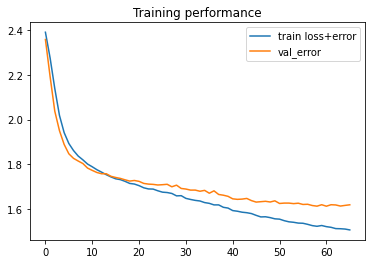

In [23]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [24]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

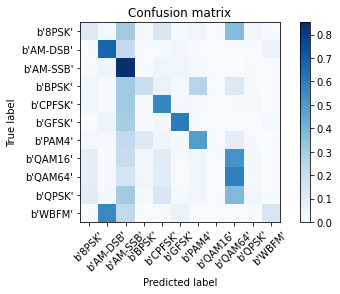

In [25]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [26]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []


snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])


#print(snr_label_array)
y_test_snr=snr_array[test_idx]



for snr in snr_label_array:
    test_X_i = X_test[np.where(y_test_snr==snr)]
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))

print("Random Guess Accuracy:",1/11)

Overall Accuracy:  0.08800287356321838 for SNR b'-20'
Overall Accuracy:  0.09582040518342763 for SNR b'-18'
Overall Accuracy:  0.09267940858276236 for SNR b'-16'
Overall Accuracy:  0.10095098756400878 for SNR b'-14'
Overall Accuracy:  0.13798033958891867 for SNR b'-12'
Overall Accuracy:  0.21114585249218318 for SNR b'-10'
Overall Accuracy:  0.28994082840236685 for SNR b'-8'
Overall Accuracy:  0.35282294902247396 for SNR b'-6'
Overall Accuracy:  0.4410182861240588 for SNR b'-4'
Overall Accuracy:  0.4892883079157589 for SNR b'-2'
Overall Accuracy:  0.5373024623300258 for SNR b'0'
Overall Accuracy:  0.5477140783744557 for SNR b'2'
Overall Accuracy:  0.5328453796889295 for SNR b'4'
Overall Accuracy:  0.5461383232434416 for SNR b'6'
Overall Accuracy:  0.5370370370370371 for SNR b'8'
Overall Accuracy:  0.5242925787506674 for SNR b'10'
Overall Accuracy:  0.5315856544693246 for SNR b'12'
Overall Accuracy:  0.5410373066424022 for SNR b'14'
Overall Accuracy:  0.539288969917958 for SNR b'16'
Over

In [27]:
print(acc_array)

[0.08800287356321838, 0.09582040518342763, 0.09267940858276236, 0.10095098756400878, 0.13798033958891867, 0.21114585249218318, 0.28994082840236685, 0.35282294902247396, 0.4410182861240588, 0.4892883079157589, 0.5373024623300258, 0.5477140783744557, 0.5328453796889295, 0.5461383232434416, 0.5370370370370371, 0.5242925787506674, 0.5315856544693246, 0.5410373066424022, 0.539288969917958, 0.5430206794682423]


In [29]:
dr_01 = [0.08800287356321838, 0.09582040518342763, 0.09267940858276236, 0.10095098756400878, 0.13798033958891867, 0.21114585249218318, 0.28994082840236685, 0.35282294902247396, 0.4410182861240588, 0.4892883079157589, 0.5373024623300258, 0.5477140783744557, 0.5328453796889295, 0.5461383232434416, 0.5370370370370371, 0.5242925787506674, 0.5315856544693246, 0.5410373066424022, 0.539288969917958, 0.5430206794682423];
dr_04 = [0.08710488505747127, 0.09417776966599745, 0.09646592138478183, 0.1071689831748354, 0.1415549597855228, 0.22328489976089755, 0.2964127218934911, 0.377854924173214, 0.46360702760846184, 0.49546114742193176, 0.5316060271958839, 0.5235849056603774, 0.5141811527904849, 0.5268758026050266, 0.5203164329377922, 0.5082754938601175, 0.5104678681958856, 0.5266606005459509, 0.5223336371923427, 0.5254800590841949];
dr_06 = [0.08979885057471264, 0.09472531483847417, 0.09484313018391634, 0.08778346744696415, 0.09597855227882038, 0.14677211697627368, 0.17806952662721892, 0.2408185638589439, 0.36608103262818215, 0.42592592592592593, 0.4566335905916942, 0.46752539912917274, 0.4602012808783166, 0.4654191891396074, 0.47680690399137, 0.47339384232069764, 0.4705989441106863, 0.46824385805277524, 0.4725615314494075, 0.47488921713441656]; 

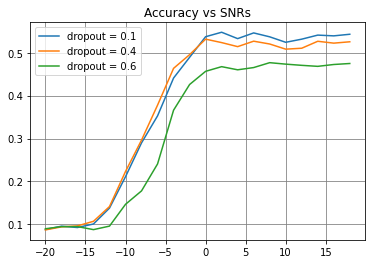

In [30]:
# Show loss curves 
plt.figure()
plt.title('Accuracy vs SNRs')
plt.grid(linestyle="-", color='grey')
plt.plot(np.arange(-20,20,2), dr_01,label = 'dropout = 0.1')
plt.plot(np.arange(-20,20,2),dr_04,label = 'dropout = 0.4')
plt.plot(np.arange(-20,20,2),dr_06,label = 'dropout = 0.6')
plt.legend(loc="upper left")

In [31]:
bs_256 = [0.09051724137931035, 0.09472531483847417, 0.10187522538766679, 0.12088514996342356, 0.17229669347631815, 0.23597572190546257, 0.30122041420118345, 0.3789512150557281, 0.44030118321979206, 0.49691358024691357, 0.595553105475928, 0.6184687953555879, 0.5952424519670632, 0.603558980003669, 0.5963682128730673, 0.597793201637302, 0.5898416166029492, 0.600181983621474, 0.6020054694621696, 0.59102658788774];
bs_1024 = [0.08800287356321838, 0.09600292024091987, 0.09754778218535881, 0.11356986100950987, 0.16300268096514745, 0.22659554901600149, 0.2869822485207101, 0.3637858578476156, 0.4164575116529222, 0.4529774872912128, 0.5520029400955531, 0.5959724238026125, 0.5912168344007319, 0.5982388552559164, 0.6021215390147429, 0.592988076170137, 0.5911159657746222, 0.6036396724294814, 0.5963536918869644, 0.5917651403249631];
bs_5000 = [0.08800287356321838, 0.09582040518342763, 0.09267940858276236, 0.10095098756400878, 0.13798033958891867, 0.21114585249218318, 0.28994082840236685, 0.35282294902247396, 0.4410182861240588, 0.4892883079157589, 0.5373024623300258, 0.5477140783744557, 0.5328453796889295, 0.5461383232434416, 0.5370370370370371, 0.5242925787506674, 0.5315856544693246, 0.5410373066424022, 0.539288969917958, 0.5430206794682423];

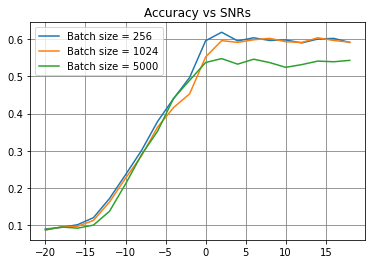

In [32]:
# Show loss curves 
plt.figure()
plt.title('Accuracy vs SNRs')
plt.grid(linestyle="-", color='grey')
plt.plot(np.arange(-20,20,2), bs_256,label = 'Batch size = 256')
plt.plot(np.arange(-20,20,2),bs_1024,label = 'Batch size = 1024')
plt.plot(np.arange(-20,20,2),bs_5000,label = 'Batch size = 5000')
plt.legend(loc="upper left")